In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import os
import shutil
from glob import glob
# importing math module  
import math 
# Importing the statistics module
import statistics

import skimage.io as io
#for text
import cv2

#filter
import skimage.filters
#adjust intensity
from skimage.exposure import rescale_intensity

#morphology
import skimage.morphology
from scipy import ndimage as ndi
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, util, measure
from scipy.ndimage import binary_dilation


# Import threshold and gray convertor functions
from skimage.filters import try_all_threshold, threshold_otsu, threshold_multiotsu
from skimage.color import rgb2gray, label2rgb

#watershed
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

#exposure
from skimage import exposure


In [3]:
#Function
def show_image(image, cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.axis('off')
    plt.show()

## Collecting data

In [9]:
#new image folder
dst_dir = '/Users/danielaagarcia-soriano/Library/Mobile Documents/com~apple~CloudDocs/Documents/2019_Postdoc_Torring/Segmentation-ML/Segmentation-ML-git/AllImages'
#os.makedirs(dst_dir, exist_ok=True)

In [30]:
#copy all image files

#01-FirstRound
#src_dir = '/Users/danielaagarcia-soriano/Documents/Academic/2019_Postdoc_TorringLab/ImageAnalysis/01-FirstRound/_PerSample/DataRaw'

#02-SecondRound
#src_dir = '/Users/danielaagarcia-soriano/Documents/Academic/2019_Postdoc_TorringLab/ImageAnalysis/02-SecondRound/10%NBA(190exp)/_PerSample/RawData'

#03-ThirdRound
# src_dir = '/Users/danielaagarcia-soriano/Documents/Academic/2019_Postdoc_TorringLab/ImageAnalysis/03-ThirdRound/time0'
src_dir = '/Users/danielaagarcia-soriano/Documents/Academic/2019_Postdoc_TorringLab/ImageAnalysis/03-ThirdRound/time1/IDs/'


In [ ]:
# Iterate over subdirectories and then files in the source directory. Needed for round 1 and 2
for subdir in os.listdir(src_dir):
    Define the source and destination file paths
    src_subdir = os.path.join(src_dir, subdir)
    #src_subdir = os.path.join(src_dir, 'tif')

    if os.path.isdir(src_subdir):
        for filename in os.listdir(src_subdir):
            src_file = os.path.join(src_subdir, filename)
            dst_file = os.path.join(dst_dir, filename)
            #print(src_file)
            
            # Copy the file to the destination directory
            shutil.copy(src_file, dst_file)

            # # Rename the file
            #new_filename = 'FirstRound_' + filename
            new_filename = 'SecondRoundNBA_' + filename
            new_file = os.path.join(dst_dir, new_filename)
            os.rename(dst_file, new_file)

In [ ]:
# Iterate over files.Needed for round 3
src_subdir = os.path.join(src_dir, 'tif')

if os.path.isdir(src_subdir):
    for filename in os.listdir(src_subdir):
        src_file = os.path.join(src_subdir, filename)
        dst_file = os.path.join(dst_dir, filename)
        #print(src_file)
            
        # Copy the file to the destination directory
        shutil.copy(src_file, dst_file)

        # Rename the file
        #new_filename = 'FirstRound_' + filename
        new_filename = 'ThirdRound_t1_' + filename
        new_file = os.path.join(dst_dir, new_filename)
        os.rename(dst_file, new_file)

## Creating new labels

In [141]:
paths = sorted(glob("dataTraining/images/*.tif"))
file = paths[0].split('/')[2]
name = file.split('.')[0]
name


'dataTraining'

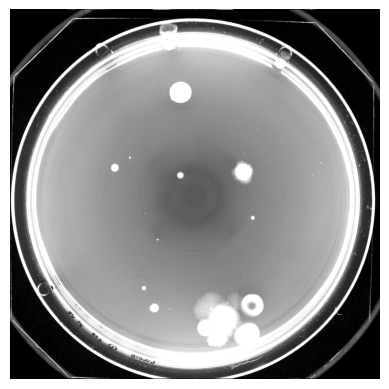

In [151]:
img = cv2.imread(paths[5])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#rgbiR = rgb2gray(image[:,:,0]) #no need to convert to gray since it is already a single channel, but segmentation is bad. #home
rgbiR = image[:,:,0] #work
p10, p90 = np.percentile(rgbiR, (10,90))
rgbIR = rescale_intensity(rgbiR, in_range=(p10, p90))
show_image(rgbIR)


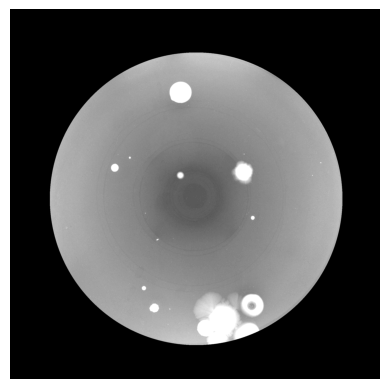

In [152]:
imageSize = rgbIR.shape
ci = [1030, 1050, 810]
#Generate grid same size as the original image
x = np.arange(0,imageSize[0])-ci[0]
y = np.arange(0,imageSize[1])-ci[1]
xx, yy = np.meshgrid(x, y)
#Generate mask
mask = (xx**2 + yy**2) < ci[2]**2
#Turn mask into integer
mask = mask.astype(int)
#plt.imshow(mask)
rgbI_mask=mask*rgbIR
show_image(rgbI_mask)

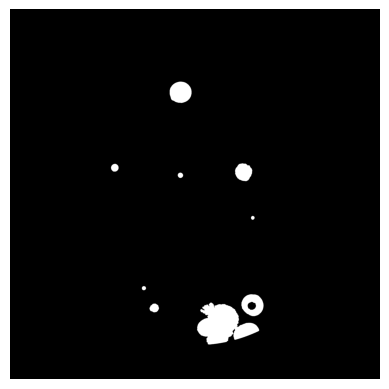

In [153]:
#For bright colonies
image_threshold_bright = rgbI_mask >= 210
image_local_open = skimage.morphology.binary_opening(image_threshold_bright, footprint=skimage.morphology.disk(5)) #work
#image_local_open = skimage.morphology.binary_opening(image_threshold_bright, selem=skimage.morphology.disk(2)) #home
image_area_closing = skimage.morphology.area_closing(image_local_open)
binary_image_bright = image_area_closing
show_image(binary_image_bright)

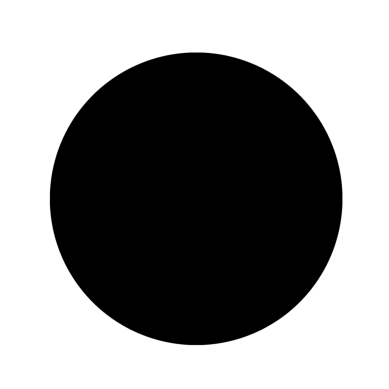

In [154]:
#For dark colonies
image_threshold_dark = rgbI_mask < 50
image_local_open = skimage.morphology.binary_opening(image_threshold_dark, footprint=skimage.morphology.disk(5))
#image_local_open = skimage.morphology.binary_opening(image_threshold_dark, selem=skimage.morphology.disk(2)) #home
image_area_closing = skimage.morphology.area_closing(image_local_open)
binary_image_dark = image_area_closing
show_image(binary_image_dark)

In [155]:
#Fused bright and dark images
binary_image = (binary_image_bright + binary_image_dark) * mask

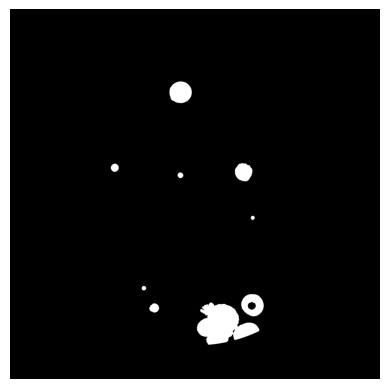

In [156]:
# Assuming `binary_image` is your binary image
binary_image_dil = binary_dilation(binary_image, border_value=0, iterations=1)
show_image(binary_image_dil)

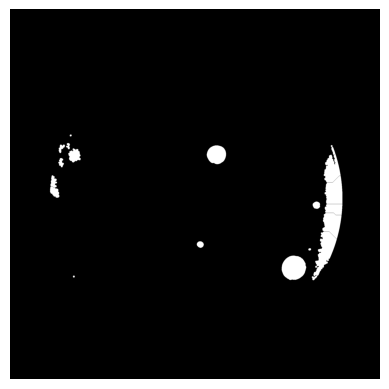

In [134]:
#watershed
distance = ndi.distance_transform_edt(binary_image)

local_max_coords = peak_local_max(distance, min_distance=30, num_peaks_per_label=1)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)
segmented_bact = watershed(-distance, markers, mask=binary_image, watershed_line=True)
segmented_bact_BW = np.array((segmented_bact > 1)*1)
show_image(segmented_bact_BW)


In [157]:
# Filtering
#label image for mapping
image_labeled = label(binary_image)
#show_image(image_labeled)

# analyze regions
regions = regionprops_table(image_labeled, properties = ('label','centroid', 'area', 
'equivalent_diameter', 'eccentricity')) #dictionary of arrays

# First filter out small objects
# Create a mask based on 'area' and 'eccentricity'
mask = (regions['area'] > 150) & (regions['area'] < 500000) & (regions['eccentricity'] < 0.8)
# Apply the mask to each array in the dictionary
filtered_regions = {prop: np.array(values)[mask] for prop, values in regions.items()}
#filtered_regions['centroid-0'][0]

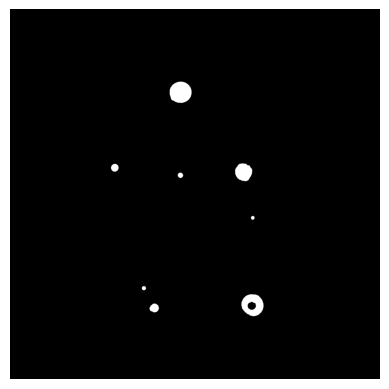

In [158]:
#Second filter out objects close to the border
idx = []
th = np.arange(0,2*np.pi,np.pi/5)
for i in range(filtered_regions['label'].shape[0]):
    #Fit a circle
    xunit = filtered_regions['equivalent_diameter'][i]/2 * np.cos(th) + filtered_regions['centroid-0'][i]
    yunit = filtered_regions['equivalent_diameter'][i]/2 * np.sin(th) + filtered_regions['centroid-1'][i]
    #Find within the boundaries. Check ci variable
    y1 = np.array(yunit>250) 
    y2 = np.array(yunit<1845)
    x1 = np.array(xunit>250)
    x2 = np.array(xunit<1845)
    xy = y1 & y2 & x1 & x2
    mean_xy = np.mean(np.multiply(xy, 1))
    if mean_xy == 1:
        idx.append(filtered_regions['label'][i])

labels_to_keep = np.array(idx)
# Create a new binary image with only the labels you want to keep
filtered_image = np.isin(image_labeled, labels_to_keep)
show_image(filtered_image)

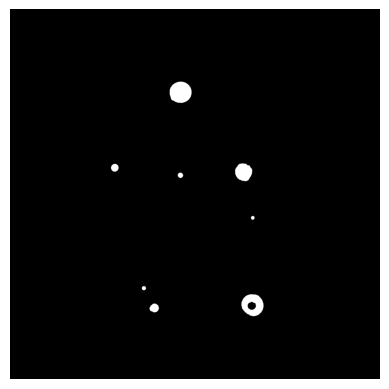

In [159]:
# Create a new binary image with only the labels you want to keep
filtered_image = np.isin(image_labeled, labels_to_keep)
show_image(filtered_image)

In [18]:
image_BW = exposure.rescale_intensity(filtered_image, out_range=(0, 255))
image_BW = image_BW.astype(np.uint8)
#save image
#name_image_binary = ('.dataTraining/bw/'+name+'_BW.tif')
#cv2.imwrite(name_image_binary, image_BW)

In [19]:
#save image
name_image_binary = ('./AllLabels/'+name+'_BW.tif')
cv2.imwrite(name_image_binary, image_BW)

True

## Loop in all data

In [161]:
paths = sorted(glob("dataTraining/images/*.tif"))
#paths = paths[0:3]
#file = paths[0].split('/')[2]
#name = file.split('.')[0]
#name

for path in paths:
    file = path.split('/')[2]
    name = file.split('.')[0]
    #print(name)

    #path = os.path.join(folder, file)

    #read image and rescale intensity
    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #rgbiR = rgb2gray(image[:,:,0]) #no need to convert to gray since it is already a single channel, but segmentation is bad. #home
    rgbiR = image[:,:,0] #work
    p10, p90 = np.percentile(rgbiR, (10,90))
    rgbIR = rescale_intensity(rgbiR, in_range=(p10, p90))

    #create mask
    imageSize = rgbIR.shape
    ci = [1030, 1050, 810]
    #Generate grid same size as the original image
    x = np.arange(0,imageSize[0])-ci[0]
    y = np.arange(0,imageSize[1])-ci[1]
    xx, yy = np.meshgrid(x, y)
    #Generate mask
    mask = (xx**2 + yy**2) < ci[2]**2
    #Turn mask into integer
    mask = mask.astype(int)
    #plt.imshow(mask)
    rgbI_mask=mask*rgbIR

    #Segment bright colonies
    image_threshold_bright = rgbI_mask >= 210
    image_local_open = skimage.morphology.binary_opening(image_threshold_bright, footprint=skimage.morphology.disk(5)) #work
    #image_local_open = skimage.morphology.binary_opening(image_threshold_bright, selem=skimage.morphology.disk(5)) #home
    image_area_closing = skimage.morphology.area_closing(image_local_open)
    binary_image_bright = image_area_closing

    #Segment dark colonies
    image_threshold_dark = rgbI_mask < 50
    image_local_open = skimage.morphology.binary_opening(image_threshold_dark, footprint=skimage.morphology.disk(5))
    #image_local_open = skimage.morphology.binary_opening(image_threshold_dark, selem=skimage.morphology.disk(5)) #home
    image_area_closing = skimage.morphology.area_closing(image_local_open)
    binary_image_dark = image_area_closing

    #Fused bright and dark images
    binary_image = (binary_image_bright + binary_image_dark) * mask

    #watershed
    # distance = ndi.distance_transform_edt(binary_image)
    # local_max_coords = peak_local_max(distance, min_distance=30, num_peaks_per_label=1)
    # local_max_mask = np.zeros(distance.shape, dtype=bool)
    # local_max_mask[tuple(local_max_coords.T)] = True
    # markers = measure.label(local_max_mask)
    # segmented_bact = watershed(-distance, markers, mask=binary_image, watershed_line=True)
    # segmented_bact_BW = np.array((segmented_bact > 1)*1)

    # Filtering
    #image_labeled = label(segmented_bact_BW)
    image_labeled = label(binary_image)
    regions = regionprops_table(image_labeled, properties = ('label','centroid', 'area', 'equivalent_diameter', 'eccentricity')) #dictionary of arrays

    # First filter out small objects
    mask = (regions['area'] > 150) & (regions['area'] < 500000) & (regions['eccentricity'] < 0.8)
    filtered_regions = {prop: np.array(values)[mask] for prop, values in regions.items()}

    #Second filter out objects close to the border
    idx = []
    th = np.arange(0,2*np.pi,np.pi/5)
    for i in range(filtered_regions['label'].shape[0]):
        #Fit a circle
        xunit = filtered_regions['equivalent_diameter'][i]/2 * np.cos(th) + filtered_regions['centroid-0'][i]
        yunit = filtered_regions['equivalent_diameter'][i]/2 * np.sin(th) + filtered_regions['centroid-1'][i]
        #Find within the boundaries. Check ci variable
        y1 = np.array(yunit>200) 
        y2 = np.array(yunit<1845)
        x1 = np.array(xunit>200)
        x2 = np.array(xunit<1845)
        xy = y1 & y2 & x1 & x2
        mean_xy = np.mean(np.multiply(xy, 1))
        if mean_xy == 1:
            idx.append(filtered_regions['label'][i])

    labels_to_keep = np.array(idx)
    # Create a new binary image with only the labels you want to keep
    filtered_image = np.isin(image_labeled, labels_to_keep)

    #rescale intensity and convert to 8-bit
    image_BW = exposure.rescale_intensity(filtered_image, out_range=(0, 255))
    image_BW = image_BW.astype(np.uint8)

    #save image
    name_image_binary = ('dataTraining/bw/'+name+'_BW.tif')
    cv2.imwrite(name_image_binary, image_BW)   

In [ ]:
for file in files:
    name = file.split('.')[0]
    #print(name)

    path = os.path.join(folder, file)

    #read image and rescale intensity
    img = cv2.imread(os.path.join(folder, file))
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #rgbiR = rgb2gray(image[:,:,0]) #no need to convert to gray since it is already a single channel, but segmentation is bad. #home
    rgbiR = image[:,:,0] #work
    p10, p90 = np.percentile(rgbiR, (10,90))
    rgbIR = rescale_intensity(rgbiR, in_range=(p10, p90))

    #create mask
    imageSize = rgbIR.shape
    ci = [1030, 1050, 840]
    #Generate grid same size as the original image
    x = np.arange(0,imageSize[0])-ci[0]
    y = np.arange(0,imageSize[1])-ci[1]
    xx, yy = np.meshgrid(x, y)
    #Generate mask
    mask = (xx**2 + yy**2) < ci[2]**2
    #Turn mask into integer
    mask = mask.astype(int)
    #plt.imshow(mask)
    rgbI_mask=mask*rgbIR

    #Segment bright colonies
    image_threshold_bright = rgbI_mask >= 200
    image_local_open = skimage.morphology.binary_opening(image_threshold_bright, footprint=skimage.morphology.disk(5)) #work
    #image_local_open = skimage.morphology.binary_opening(image_threshold_bright, selem=skimage.morphology.disk(5)) #home
    image_area_closing = skimage.morphology.area_closing(image_local_open)
    binary_image_bright = image_area_closing

    #Segment dark colonies
    image_threshold_dark = rgbI_mask < 40
    image_local_open = skimage.morphology.binary_opening(image_threshold_dark, footprint=skimage.morphology.disk(5))
    #image_local_open = skimage.morphology.binary_opening(image_threshold_dark, selem=skimage.morphology.disk(5)) #home
    image_area_closing = skimage.morphology.area_closing(image_local_open)
    binary_image_dark = image_area_closing

    #Fused bright and dark images
    binary_image = (binary_image_bright + binary_image_dark) * mask

    #watershed
    # distance = ndi.distance_transform_edt(binary_image)
    # local_max_coords = peak_local_max(distance, min_distance=30, num_peaks_per_label=1)
    # local_max_mask = np.zeros(distance.shape, dtype=bool)
    # local_max_mask[tuple(local_max_coords.T)] = True
    # markers = measure.label(local_max_mask)
    # segmented_bact = watershed(-distance, markers, mask=binary_image, watershed_line=True)
    # segmented_bact_BW = np.array((segmented_bact > 1)*1)

    # Filtering
    #image_labeled = label(segmented_bact_BW)
    image_labeled = label(binary_image)
    regions = regionprops_table(image_labeled, properties = ('label','centroid', 'area', 'perimeter', 
    'equivalent_diameter', 'eccentricity', 'convex_area')) #dictionary of arrays

    # First filter out small objects
    mask = (regions['area'] > 60) & (regions['area'] < 500000) & (regions['eccentricity'] < 0.8)
    filtered_regions = {prop: np.array(values)[mask] for prop, values in regions.items()}

    #Second filter out objects close to the border
    idx = []
    th = np.arange(0,2*np.pi,np.pi/5)
    for i in range(filtered_regions['label'].shape[0]):
        #Fit a circle
        xunit = filtered_regions['equivalent_diameter'][i]/2 * np.cos(th) + filtered_regions['centroid-0'][i]
        yunit = filtered_regions['equivalent_diameter'][i]/2 * np.sin(th) + filtered_regions['centroid-1'][i]
        #Find within the boundaries. Check ci variable
        y1 = np.array(yunit>200) 
        y2 = np.array(yunit<1845)
        x1 = np.array(xunit>200)
        x2 = np.array(xunit<1845)
        xy = y1 & y2 & x1 & x2
        mean_xy = np.mean(np.multiply(xy, 1))
        if mean_xy == 1:
            idx.append(filtered_regions['label'][i])

    labels_to_keep = np.array(idx)
    # Create a new binary image with only the labels you want to keep
    filtered_image = np.isin(image_labeled, labels_to_keep)

    #rescale intensity and convert to 8-bit
    image_BW = exposure.rescale_intensity(filtered_image, out_range=(0, 255))
    image_BW = image_BW.astype(np.uint8)

    #save image
    name_image_binary = ('./AllLabels/'+name+'_BW.tif')
    cv2.imwrite(name_image_binary, image_BW)   

## Edit the output

In [21]:

for file in files:
    name = file.split('.')[0]
    #print(name)

    path = os.path.join(folder, file)

    img = cv2.imread(path, 1)
    #img = cv2.imread('./images//round1/Clara_10%NB_10-3.tif', 1)
    #convert BGR to RGB
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #show_image(image)

    rgbiR = rgb2gray(image[:,:,0])
    p10, p90 = np.percentile(rgbiR, (10,90))
    rgbIR = rescale_intensity(rgbiR, in_range=(p10, p90))
    #show_image(rgbiR)

    #save image
    name_image_binary = (name+'_BW.tiff')
    cv2.imwrite(name_image_binary, rgbiR)

/Users/danielaagarcia-soriano/anaconda3/envs/ia-ML-env/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  del sys.path[0]
